In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch

from network import Net
from diff_equations import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(69)
np.random.seed(69)


Text(0.5, 0, 'Time (s)')

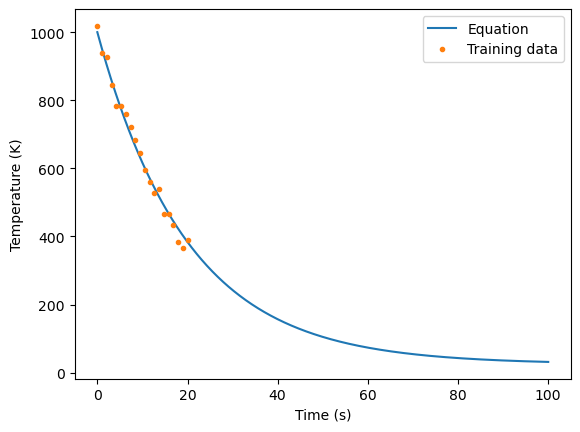

In [2]:
Tenv = 25
T0 = 1000
R = 0.05
times = np.linspace(0, 100, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 20, 20)
y = eq(t) + 20 * np.random.randn(20)

plt.plot(times, temps)
plt.plot(t, y, '.')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')


# Vanilla Network

Epoch 0/1000, loss: 450390.72
Epoch 100/1000, loss: 107932.00
Epoch 200/1000, loss: 1518.25
Epoch 300/1000, loss: 552.54
Epoch 400/1000, loss: 380.02
Epoch 500/1000, loss: 312.15
Epoch 600/1000, loss: 266.87
Epoch 700/1000, loss: 238.77
Epoch 800/1000, loss: 229.91
Epoch 900/1000, loss: 213.93


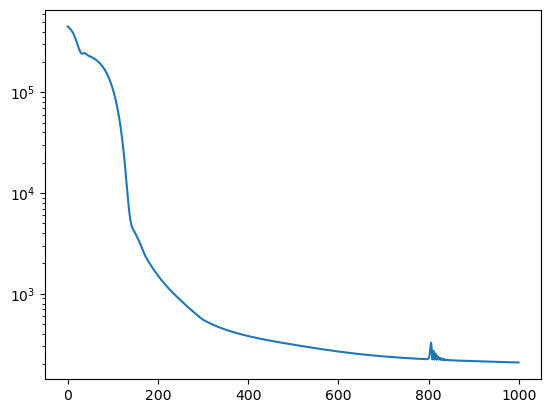

In [3]:
net = Net(1,1, pde_loss=None, epochs=1000, lr=5e-3).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

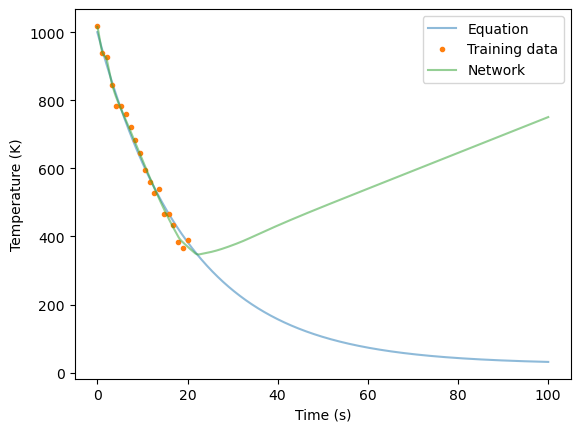

In [4]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# Standard L2 Regularisation

In [5]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/1000, loss: 456942.34
Epoch 100/1000, loss: 147785.44
Epoch 200/1000, loss: 15741.84
Epoch 300/1000, loss: 13306.02
Epoch 400/1000, loss: 11715.22
Epoch 500/1000, loss: 10578.23
Epoch 600/1000, loss: 9738.39
Epoch 700/1000, loss: 9106.46
Epoch 800/1000, loss: 8605.08
Epoch 900/1000, loss: 8234.68


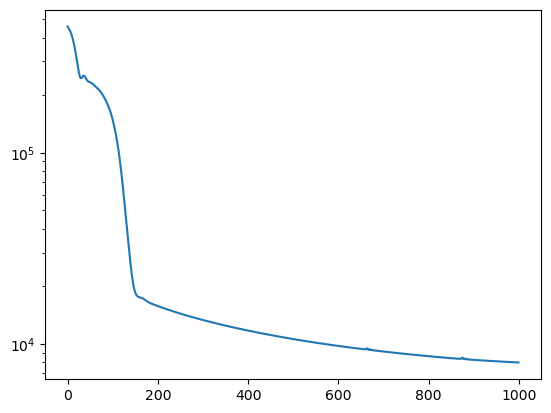

In [6]:
net = Net(1,1, pde_loss=l2_reg, epochs=1000, lr=5e-3, phys_weight=1).to(DEVICE)

losses = net.fit(t, y)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

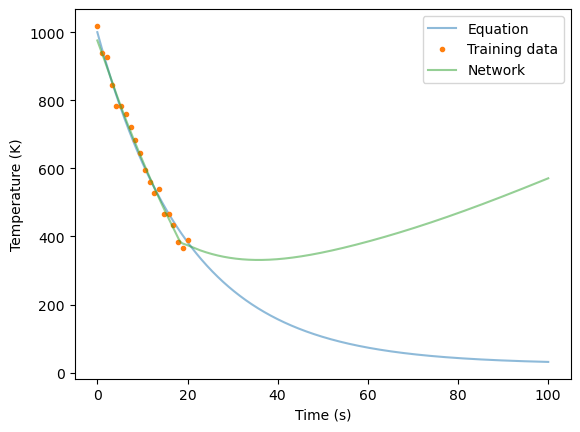

In [7]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')

# PINN

In [8]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 100, steps=30,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/2000, loss: 449186.16
Epoch 200/2000, loss: 1036.03
Epoch 400/2000, loss: 301.26
Epoch 600/2000, loss: 258.24
Epoch 800/2000, loss: 232.19
Epoch 1000/2000, loss: 212.65
Epoch 1200/2000, loss: 201.00
Epoch 1400/2000, loss: 188.47
Epoch 1600/2000, loss: 180.81
Epoch 1800/2000, loss: 176.12


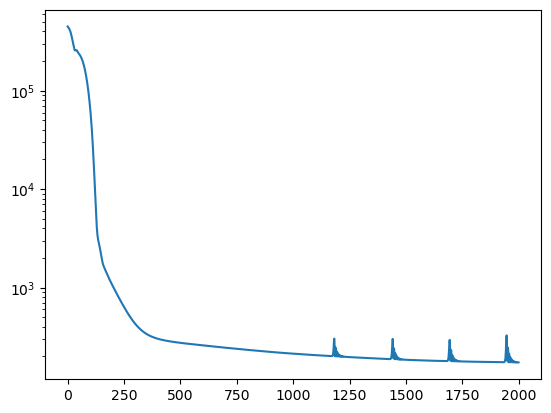

In [11]:
net = Net(1,1, pde_loss=physics_loss, epochs=2000, phys_weight=1, lr=5e-3).to(DEVICE)

losses = net.fit(t, y)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

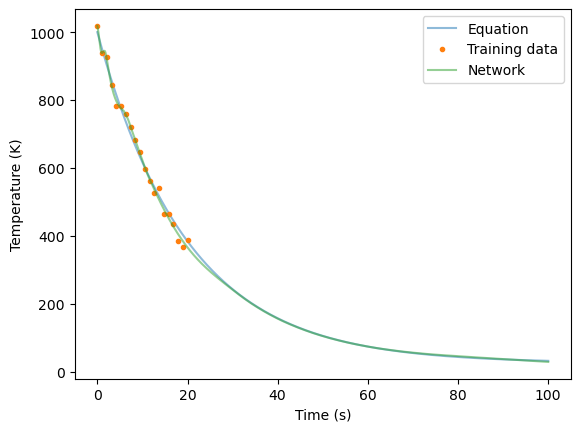

In [12]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.5)
plt.plot(t, y, '.')
plt.plot(times, preds, alpha=0.5)
plt.legend(labels=['Equation','Training data', 'Network'])
plt.ylabel('Temperature (K)')
plt.xlabel('Time (s)')